In [1]:
# Cell 0: imports & settings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 50)
sns.set(style="whitegrid", context="notebook")


# 1. Read data, EDA, feature engineering

In [2]:
# Cell 1: read the CSV (update filename if needed)

df_raw = pd.read_csv("https://raw.githubusercontent.com/raheems/icasds2025/main/data/clinicaltrials_1000_cancer.csv")

df_raw.head()

,nct_id,brief_title,phase,conditions,overall_status,enrollment_count,num_locations,num_countries,countries,start_date,primary_completion_date
0,NCT03315195,Preoperative Oral Nutritional Supplement vs Co...,NaN,"Surgery--Complications, Nutrition Aspect of Ca...",UNKNOWN,268.0,1,1,Thailand,2017-11-25,2021-11
1,NCT02606539,Surgery Plus Single Agent Chemotherapy Versus ...,PHASE2,Gestational Trophoblastic Neoplasms,UNKNOWN,20.0,2,1,Egypt,2015-09,2017-06
2,NCT07021677,"Use of a New Medicine ""Daratumumab"" to Treat L...",PHASE2,T Acute Lymphoblastic Leukemia,RECRUITING,18.0,1,1,India,2023-08-28,2026-08-28
3,NCT01308775,Comparing (SIS.NET) to Standard Care in Patien...,NaN,Breast Cancer,COMPLETED,102.0,1,1,United States,2011-01,2014-03
4,NCT05038657,"Atezolizumab Immunotherapy, in Immunotherapy N...",PHASE2,"Squamous Cell Carcinoma, Urinary Tract Cancer",UNKNOWN,36.0,1,1,United Kingdom,2022-05-30,2024-01


In [3]:
# Cell 2: basic info & missingness

df_raw.info()
df_raw.isna().mean().sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   nct_id                   1000 non-null   object 
 1   brief_title              1000 non-null   object 
 2   phase                    588 non-null    object 
 3   conditions               1000 non-null   object 
 4   overall_status           1000 non-null   object 
 5   enrollment_count         976 non-null    float64
 6   num_locations            1000 non-null   int64  
 7   num_countries            1000 non-null   int64  
 8   countries                909 non-null    object 
 9   start_date               989 non-null    object 
 10  primary_completion_date  950 non-null    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 86.1+ KB


,0
phase,0.412
countries,0.091
primary_completion_date,0.050
enrollment_count,0.024
start_date,0.011
brief_title,0.000
nct_id,0.000
num_locations,0.000
overall_status,0.000
conditions,0.000


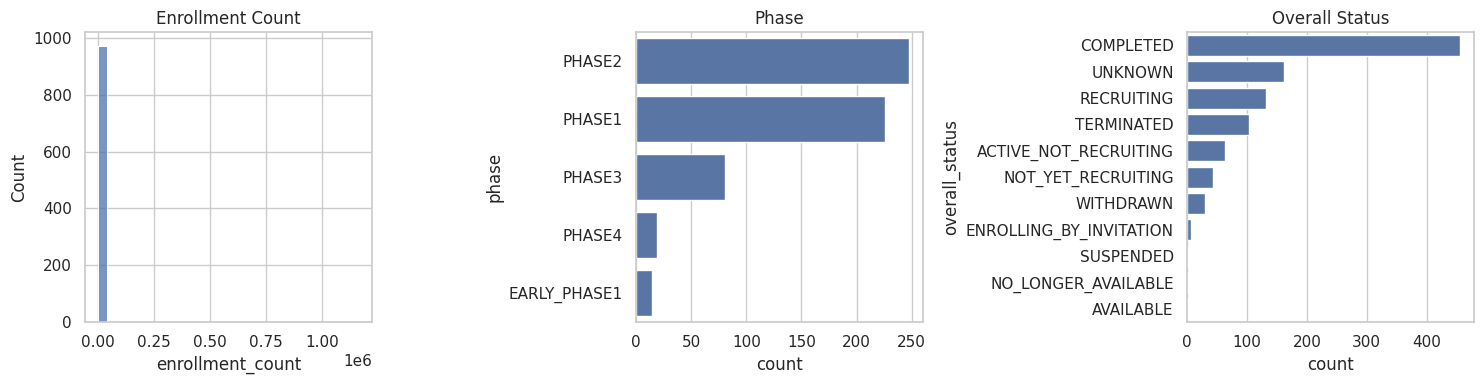

In [4]:
# Cell 3: quick distributions

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(df_raw["enrollment_count"], kde=False, bins=30, ax=axes[0])
axes[0].set_title("Enrollment Count")

sns.countplot(y="phase", data=df_raw, order=df_raw["phase"].value_counts().index, ax=axes[1])
axes[1].set_title("Phase")

sns.countplot(y="overall_status", data=df_raw,
              order=df_raw["overall_status"].value_counts().index, ax=axes[2])
axes[2].set_title("Overall Status")

plt.tight_layout()
plt.show()


In [5]:
# Cell 4: basic cleaning & target creation

df = df_raw.copy()

# keep only rows with enrollment_count
df = df[df["enrollment_count"].notna()].copy()
df["enrollment_count"] = pd.to_numeric(df["enrollment_count"], errors="coerce")
df = df[df["enrollment_count"].notna()].copy()

# define binary target: 1 = high enrollment (>= median), 0 = low enrollment
threshold = df["enrollment_count"].median()
print("Median enrollment threshold:", threshold)

df["success"] = (df["enrollment_count"] >= threshold).astype(int)
df["success"].value_counts(normalize=True)


Median enrollment threshold: 57.5


,proportion
success,
1,0.5
0,0.5


In [6]:
# Cell 5: feature engineering

# fill basic categoricals
df["phase"] = df["phase"].fillna("Unknown")
df["overall_status"] = df["overall_status"].fillna("Unknown")

# numeric counts
df["num_locations"] = df["num_locations"].fillna(0).astype(int)
df["num_countries"] = df["num_countries"].fillna(0).astype(int)

# simple derived feature: multinational
df["is_multinational"] = (df["num_countries"] > 1).astype(int)

# optional: approximate trial duration in days if dates present
for col in ["start_date", "primary_completion_date"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

if {"start_date", "primary_completion_date"}.issubset(df.columns):
    df["duration_days"] = (df["primary_completion_date"] - df["start_date"]).dt.days
else:
    df["duration_days"] = np.nan

# choose features
feature_cols = [
    "phase",
    "overall_status",
    "num_locations",
    "num_countries",
    "is_multinational",
    "duration_days",
]

df[feature_cols + ["enrollment_count", "success"]].head()


,phase,overall_status,num_locations,num_countries,is_multinational,duration_days,enrollment_count,success
0,Unknown,UNKNOWN,1,1,0,1437.0,268.0,1
1,PHASE2,UNKNOWN,2,1,0,NaN,20.0,0
2,PHASE2,RECRUITING,1,1,0,NaN,18.0,0
3,Unknown,COMPLETED,1,1,0,NaN,102.0,1
4,PHASE2,UNKNOWN,1,1,0,581.0,36.0,0


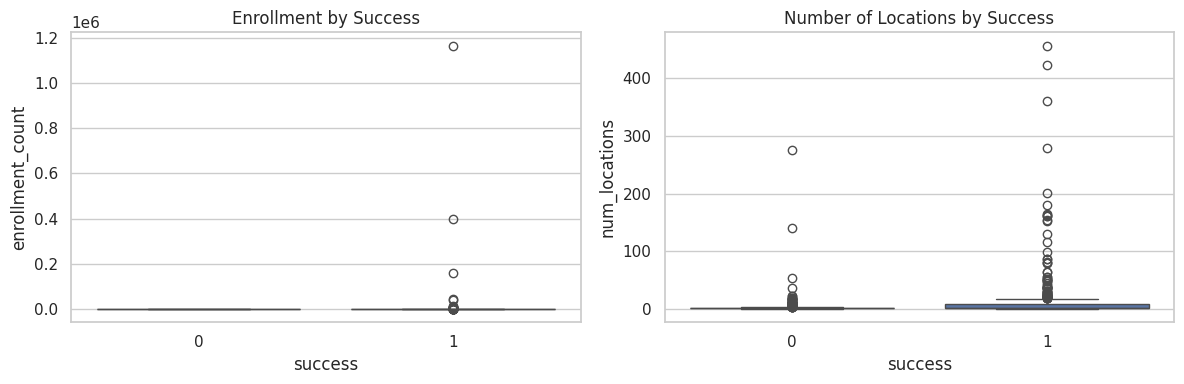

In [7]:
# Cell 6: quick relationship plots by target

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(data=df, x="success", y="enrollment_count", ax=axes[0])
axes[0].set_title("Enrollment by Success")

sns.boxplot(data=df, x="success", y="num_locations", ax=axes[1])
axes[1].set_title("Number of Locations by Success")

plt.tight_layout()
plt.show()


# 2. Descriptive summary by target using tableone

In [8]:
# Cell 7: install (only needed once in the environment)
!pip install tableone


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.0 MB/s eta 0:00:00


In [9]:
# Cell 8: descriptive summary by success group

from tableone import TableOne

# choose variables for descriptive table
columns = [
    "enrollment_count",
    "phase",
    "overall_status",
    "num_locations",
    "num_countries",
    "is_multinational",
    "duration_days",
]
categorical = ["phase", "overall_status", "is_multinational"]
groupby = "success"

table1 = TableOne(
    df,
    columns=columns,
    categorical=categorical,
    groupby=groupby,
    pval=True,
    label_suffix=True,
)

table1


Grouped by success                                                            
                                                               Missing           Overall               0                 1 P-Value
n                                                                                    976             488               488        
enrollment_count, mean (SD)                                          0  2084.9 (39805.3)     24.6 (15.5)  4145.1 (56246.5)   0.106
phase, n (%)                EARLY_PHASE1                                        14 (1.4)        13 (2.7)           1 (0.2)  <0.001
                            PHASE1                                            216 (22.1)      168 (34.4)          48 (9.8)        
                            PHASE2                                            242 (24.8)      140 (28.7)        102 (20.9)        
                            PHASE3                                              79 (8.1)        14 (2.9)         65 (13.3)        
                            PHASE4                                              19 (1.9)         8 (1.6)          11 (2.3)        
                            Unknown                                           406 (41.6)      145 (29.7)        261 (53.5)        
overall_status, n (%)       ACTIVE_NOT_RECRUITING                               63 (6.5)        29 (5.9)          34 (7.0)  <0.001
                            COMPLETED                                         438 (44.9)      228 (46.7)        210 (43.0)        
                            ENROLLING_BY_INVITATION                              7 (0.7)         0 (0.0)           7 (1.4)        
                            NOT_YET_RECRUITING                                  43 (4.4)        16 (3.3)          27 (5.5)        
                            RECRUITING                                        132 (13.5)        42 (8.6)         90 (18.4)        
                            SUSPENDED                                            1 (0.1)         0 (0.0)           1 (0.2)        
                            TERMINATED                                        103 (10.6)       73 (15.0)          30 (6.1)        
                            UNKNOWN                                           159 (16.3)       70 (14.3)         89 (18.2)        
                            WITHDRAWN                                           30 (3.1)        30 (6.1)           0 (0.0)        
num_locations, mean (SD)                                             0        8.2 (32.2)      3.2 (14.5)       13.2 (42.6)  <0.001
num_countries, mean (SD)                                             0         1.5 (2.5)       1.1 (1.0)         1.8 (3.4)  <0.001
is_multinational, n (%)     0                                                 871 (89.2)      456 (93.4)        415 (85.0)  <0.001
                            1                                                 105 (10.8)        32 (6.6)         73 (15.0)        
duration_days, mean (SD)                                           888    1427.1 (890.3)  1129.4 (703.6)    1633.2 (952.2)   0.005

# 3. Train/test split and preprocessing

In [10]:
# Cell 10: define X, y and split

from sklearn.impute import SimpleImputer

X = df[feature_cols]
y = df["success"]

cat_cols = ["phase", "overall_status"]
num_cols = ["num_locations", "num_countries", "is_multinational", "duration_days"]

# Create a numerical transformer with imputation
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", num_transformer, num_cols), # Use the numerical transformer
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((732, 6), (244, 6))

# 4. Covariate balance between train and test

# 5. Baseline model: Logistic regression

In [11]:
# Cell 11: logistic regression pipeline

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs",
)

pipe_lr = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", log_reg),
    ]
)

pipe_lr.fit(X_train, y_train)

y_pred_lr = pipe_lr.predict(X_test)
y_prob_lr = pipe_lr.predict_proba(X_test)[:, 1]


In [12]:
# Cell 12: evaluate logistic regression

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, digits=3))

auc_lr = roc_auc_score(y_test, y_prob_lr)
print("ROC AUC:", round(auc_lr, 3))

cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr


=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.718     0.648     0.681       122
           1      0.679     0.746     0.711       122

    accuracy                          0.697       244
   macro avg      0.699     0.697     0.696       244
weighted avg      0.699     0.697     0.696       244

ROC AUC: 0.782


array([[79, 43],
       [31, 91]])

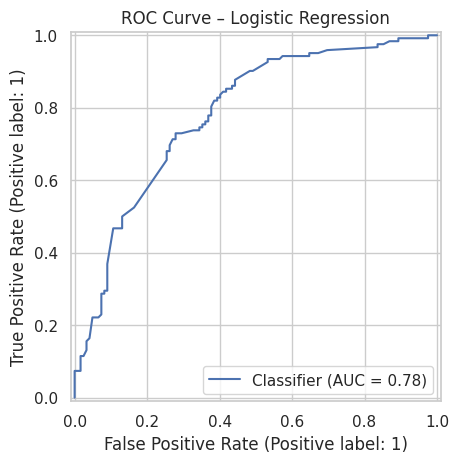

In [13]:
# Cell 13: ROC curve for logistic regression

RocCurveDisplay.from_predictions(y_test, y_prob_lr)
plt.title("ROC Curve – Logistic Regression")
plt.show()


# 6. XGBoost model

In [14]:
# Cell 14: XGBoost pipeline

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)

pipe_xgb = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", xgb_model),
    ]
)

pipe_xgb.fit(X_train, y_train)

y_pred_xgb = pipe_xgb.predict(X_test)
y_prob_xgb = pipe_xgb.predict_proba(X_test)[:, 1]


In [15]:
# Cell 15: evaluate XGBoost

print("=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb, digits=3))

auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print("ROC AUC:", round(auc_xgb, 3))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_xgb


=== XGBoost ===
              precision    recall  f1-score   support

           0      0.745     0.648     0.693       122
           1      0.688     0.779     0.731       122

    accuracy                          0.713       244
   macro avg      0.717     0.713     0.712       244
weighted avg      0.717     0.713     0.712       244

ROC AUC: 0.777


array([[79, 43],
       [27, 95]])

<Figure size 600x500 with 0 Axes>

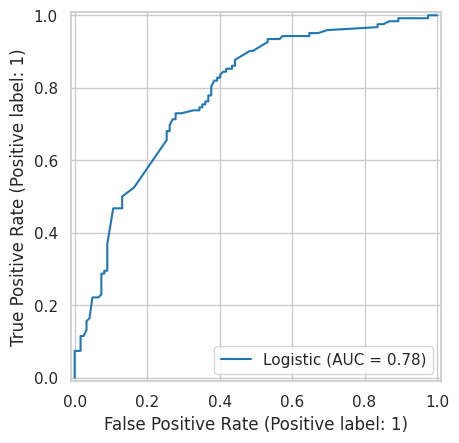

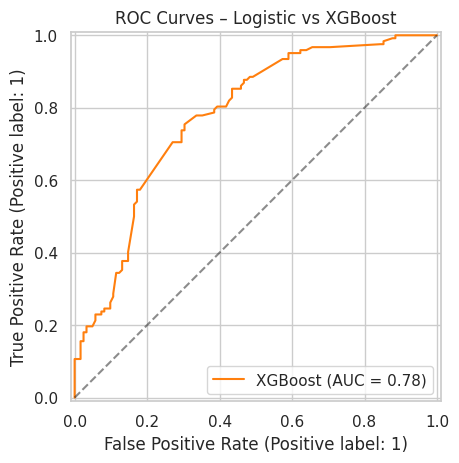

In [16]:
# Cell 16: ROC curves comparison

plt.figure(figsize=(6, 5))
RocCurveDisplay.from_predictions(y_test, y_prob_lr, name="Logistic", color="tab:blue")
RocCurveDisplay.from_predictions(y_test, y_prob_xgb, name="XGBoost", color="tab:orange")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.title("ROC Curves – Logistic vs XGBoost")
plt.show()


# 7. Simple model explanation

## 7.1. Logistic regression – coefficients (approximate)

In [17]:
# Cell 17: get feature names and coefficients for logistic regression

# 1) fit preprocessing separately on full X to get names
ohe = OneHotEncoder(handle_unknown="ignore")
ohe.fit(X[cat_cols])

cat_feature_names = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(cat_feature_names) + num_cols

# 2) fit a "plain" logistic regression on encoded data for clarity
X_enc = np.hstack([
    ohe.transform(X[cat_cols]).toarray(),
    X[num_cols].values,
])

log_plain = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs",
)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(
    X_enc, y, test_size=0.25, random_state=42, stratify=y
)
log_plain.fit(X_train_enc, y_train_enc)

coef = log_plain.coef_[0]
coef_df = pd.DataFrame({"feature": all_feature_names, "coef": coef})
coef_df.sort_values("coef", ascending=False).head(15)


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [18]:
# Cell 17: get feature names and coefficients for logistic regression

# 1) fit preprocessing separately on full X to get names
ohe = OneHotEncoder(handle_unknown="ignore")
ohe.fit(X[cat_cols])

cat_feature_names = ohe.get_feature_names_out(cat_cols)

# Create and fit a simple imputer for numerical columns
num_imputer = SimpleImputer(strategy='median')
num_imputer.fit(X[num_cols])

# Transform numerical columns using the imputer
X_num_imputed = num_imputer.transform(X[num_cols])

all_feature_names = list(cat_feature_names) + num_cols

# 2) fit a "plain" logistic regression on encoded data for clarity
X_enc = np.hstack([
    ohe.transform(X[cat_cols]).toarray(),
    X_num_imputed,
])

log_plain = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs",
)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(
    X_enc, y, test_size=0.25, random_state=42, stratify=y
)
log_plain.fit(X_train_enc, y_train_enc)

coef = log_plain.coef_[0]
coef_df = pd.DataFrame({"feature": all_feature_names, "coef": coef})
coef_df.sort_values("coef", ascending=False).head(15)

,feature,coef
8,overall_status_ENROLLING_BY_INVITATION,1.243194
3,phase_PHASE3,1.077064
9,overall_status_NOT_YET_RECRUITING,0.749133
5,phase_Unknown,0.715469
17,is_multinational,0.692468
10,overall_status_RECRUITING,0.662989
4,phase_PHASE4,0.414747
6,overall_status_ACTIVE_NOT_RECRUITING,0.325494
13,overall_status_UNKNOWN,0.134145
16,num_countries,0.080336


## 6.2. XGBoost – feature importance

In [19]:
# Cell 18: feature importance from XGBoost (approximate)

# reuse X_enc and all_feature_names from above
xgb_plain = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)
xgb_plain.fit(X_train_enc, y_train_enc)

importances = xgb_plain.feature_importances_

fi_df = pd.DataFrame({"feature": all_feature_names, "importance": importances})
fi_df = fi_df.sort_values("importance", ascending=False)

fi_df.head(15)


,feature,importance
1,phase_PHASE1,0.133492
14,overall_status_WITHDRAWN,0.109027
3,phase_PHASE3,0.072700
5,phase_Unknown,0.071067
0,phase_EARLY_PHASE1,0.068189
12,overall_status_TERMINATED,0.067718
2,phase_PHASE2,0.062085
10,overall_status_RECRUITING,0.053599
15,num_locations,0.049686
8,overall_status_ENROLLING_BY_INVITATION,0.045845


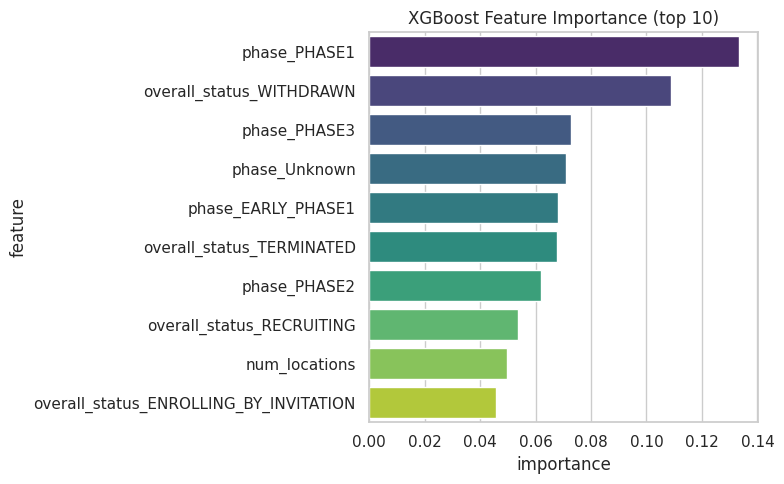

In [20]:
# Cell 19: plot top 10 features

top_k = 10
plt.figure(figsize=(8, 5))
sns.barplot(
    data=fi_df.head(top_k),
    x="importance",
    y="feature",
    palette="viridis"
)
plt.title("XGBoost Feature Importance (top 10)")
plt.tight_layout()
plt.show()


Discussion prompts:

Do the most important features match your intuition from EDA and domain logic?

How would you explain “why the model thinks a trial will succeed” to a non‑technical stakeholder, using these features and directions of effect?
​



# 1. Template: Try another classifier (e.g., Random Forest)

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1,
)

pipe_rf = Pipeline(
    steps=[
        ("preprocess", preprocess),  # reuse from earlier
        ("model", rf_model),
    ]
)

pipe_rf.fit(X_train, y_train)

y_pred_rf = pipe_rf.predict(X_test)
y_prob_rf = pipe_rf.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))


=== Random Forest ===
              precision    recall  f1-score   support

           0      0.708     0.656     0.681       122
           1      0.679     0.730     0.704       122

    accuracy                          0.693       244
   macro avg      0.694     0.693     0.692       244
weighted avg      0.694     0.693     0.692       244

ROC AUC: 0.7682074711099167


## 2. Template: Hyperparameter search (GridSearchCV)

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "model__n_estimators": [100, 300],
    "model__max_depth": [3, 5, None],
}

rf_for_search = RandomForestClassifier(
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1,
)

pipe_rf_search = Pipeline(
    steps=[("preprocess", preprocess), ("model", rf_for_search)]
)

grid = GridSearchCV(
    pipe_rf_search,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV ROC AUC:", grid.best_score_)

best_rf = grid.best_estimator_
y_prob_best = best_rf.predict_proba(X_test)[:, 1]
print("Test ROC AUC (best RF):", roc_auc_score(y_test, y_prob_best))


Best params: {'model__max_depth': 3, 'model__n_estimators': 100}
Best CV ROC AUC: 0.7855191256830601
Test ROC AUC (best RF): 0.7840970169309326


## 3. Template: Calibrated probabilities

Calibrated probabilities are crucial when you need to trust the predicted probabilities of your model as actual probabilities. Here's why they are important:

**Trustworthiness of Predictions:** If a model predicts a 70% chance of success, a well-calibrated model means that among all instances predicted with 70% probability, approximately 70% of them will actually succeed. An uncalibrated model might say 70% but only 50% or 90% actually succeed, leading to misinformed decisions.

**Decision Making:** In many real-world applications, decisions are based not just on the class prediction (e.g., 'success' or 'failure'), but on the likelihood of that outcome. For example, in medical diagnosis, a doctor might choose a treatment path based on the precise probability of a disease, not just a binary presence/absence. Uncalibrated probabilities can lead to suboptimal or even harmful decisions.

**Risk Assessment:** When assessing risk, accurate probability estimates are paramount. For instance, in fraud detection or credit scoring, predicting the exact probability of an event allows for more precise risk stratification and resource allocation.

**Combining Models/Human Judgment:** If you're combining the output of a model with other models or human expertise, it's essential that all probability estimates are on the same scale and can be directly compared. Calibrated probabilities facilitate this integration.

**Cost-Sensitive Learning:** In scenarios where false positives and false negatives have different costs, you often set decision thresholds based on predicted probabilities. If probabilities are uncalibrated, these thresholds might not yield the optimal cost-benefit balance.

Many machine learning models, especially tree-based models like XGBoost, are not naturally calibrated. While they might be good at ranking predictions (i.e., distinguishing between higher and lower probability instances), their raw probability outputs often need to be adjusted (calibrated) to reflect true probabilities.



In [23]:
from sklearn.calibration import CalibratedClassifierCV

# wrap existing best_rf (or any classifier) to improve probability calibration
calibrated = CalibratedClassifierCV(best_rf, cv=3, method="isotonic")
calibrated.fit(X_train, y_train)

y_prob_cal = calibrated.predict_proba(X_test)[:, 1]
print("Calibrated ROC AUC:", roc_auc_score(y_test, y_prob_cal))


Calibrated ROC AUC: 0.7945444772910508


## 4. Template: Cross‑validated metrics for multiple models

In [24]:
from sklearn.model_selection import cross_val_score

models = {
    "Logistic": pipe_lr,
    "XGBoost": pipe_xgb,
    "RandomForest": pipe_rf,
}

for name, model in models.items():
    scores = cross_val_score(
        model, X, y, cv=5, scoring="roc_auc", n_jobs=-1
    )
    print(f"{name}: mean AUC={scores.mean():.3f}, std={scores.std():.3f}")


Logistic: mean AUC=0.783, std=0.038
XGBoost: mean AUC=0.777, std=0.030
RandomForest: mean AUC=0.746, std=0.027


## 5. Template: Partial dependence / effect plots (tree models)

Partial Dependence Plots (PDPs) are powerful tools used in machine learning to visualize the marginal effect of one or two features on the predicted outcome of a model. They help to understand the relationship between a feature (or a pair of features) and the target variable, even in complex models like tree-based ensembles.
Here's a breakdown of what they are and why they're useful:

What they are:

**Marginal Effect:** A PDP shows how the average prediction of the model changes as the value of a specific feature (or features) changes, while holding all other features constant (or rather, averaging out their effects). It's essentially an average prediction function of a particular feature.
Model Agnostic: PDPs can be used with any supervised learning model, making them a versatile interpretability tool.

**Intuitive Visualization:** They typically present a 2D plot (for one feature) or a 3D surface/contour plot (for two features), which is easy to interpret.
Why they are useful:

**Interpretability:** They help to explain the behavior of "black box" models (like Random Forests or XGBoost) by revealing how individual features influence predictions on average.

**Feature Understanding:** They can uncover monotonic, linear, or more complex non-linear relationships between features and the target variable.

**Model Debugging:** By examining PDPs, you might identify unexpected relationships, which could indicate issues with data quality, feature engineering, or model training.

**Communication:** They provide a clear visual summary that can be easily communicated to non-technical stakeholders to explain model behavior.
How to interpret them:

- X-axis: Represents the value of the feature(s) being analyzed.

- Y-axis: Represents the partial dependence (the average predicted outcome) of the model.

- Slope/Shape: A positive slope indicates that as the feature value increases, the predicted outcome tends to increase. A negative slope indicates the opposite. A flat line suggests little to no average impact of that feature on the prediction. Curvature reveals non-linear relationships.

For example, In this example, if the line for `num_locations` shows an upward trend, it means that, on average, more locations lead to a higher predicted probability of success, holding other features constant. Conversely, if it trends downwards or stays flat, you can infer different relationships.

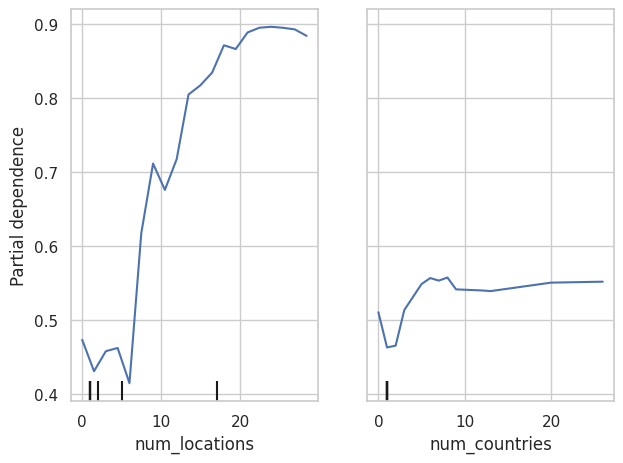

In [25]:
from sklearn.inspection import PartialDependenceDisplay

# fit a tree model on training data if not already fitted
pipe_rf.fit(X_train, y_train)

features_to_plot = ["num_locations", "num_countries"]

PartialDependenceDisplay.from_estimator(
    pipe_rf,
    X_test,
    features_to_plot,
    kind="average",
    grid_resolution=20,
)
plt.tight_layout()
plt.show()


## 6. Template: SHAP for deeper XGBoost explanation (if SHAP installed)

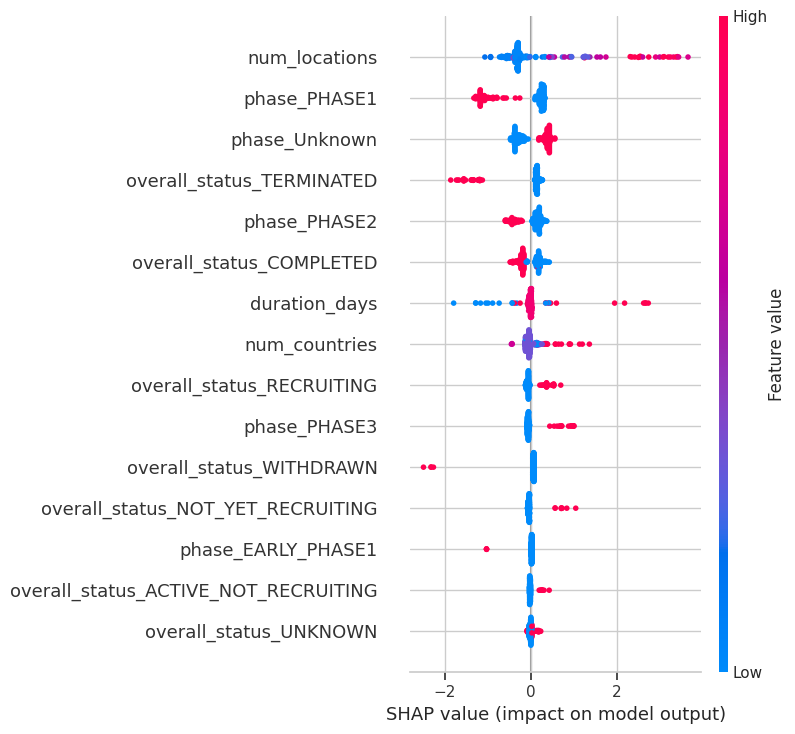

In [26]:
# !pip install shap

import shap

# fit plain XGB on encoded data (reuse X_train_enc / all_feature_names if you created them)
xgb_plain.fit(X_train_enc, y_train_enc)

explainer = shap.TreeExplainer(xgb_plain)
shap_values = explainer(X_test_enc)

shap.summary_plot(shap_values, X_test_enc, feature_names=all_feature_names, max_display=15)


## 7. Template: Error analysis – inspect misclassified cases

In [27]:
# choose a model, e.g. XGBoost pipeline
y_pred = y_pred_xgb
y_prob = y_prob_xgb

results = df.loc[X_test.index].copy()
results["y_true"] = y_test
results["y_pred"] = y_pred
results["y_prob"] = y_prob

# false negatives: actual success=1 but predicted 0
fn = results[(results["y_true"] == 1) & (results["y_pred"] == 0)]
fp = results[(results["y_true"] == 0) & (results["y_pred"] == 1)]

print("False negatives (head):")
fn.head()

print("\nFalse positives (head):")
fp.head()


False negatives (head):

False positives (head):


,nct_id,brief_title,phase,conditions,overall_status,enrollment_count,num_locations,num_countries,countries,start_date,primary_completion_date,success,is_multinational,duration_days,y_true,y_pred,y_prob
325,NCT07191977,Neoadjuvant Camrelizumab With Palbociclib for ...,PHASE2,Esophageal Squamour Cell Cancer,NOT_YET_RECRUITING,41.0,0,0,NaN,NaT,2027-12-01,0,0,NaN,0,1,0.519101
672,NCT00303901,Cryotherapy in Treating Patients With Primary ...,Unknown,"Lung Cancer, Metastatic Cancer",COMPLETED,40.0,1,1,United States,NaT,2011-07-01,0,0,NaN,0,1,0.589989
907,NCT06937281,SABR PRIMER - Evaluating Stereotactic Ablative...,Unknown,"Breast Cancer, Metastases",NOT_YET_RECRUITING,40.0,1,1,Canada,2025-07-01,NaT,0,0,NaN,0,1,0.813928
753,NCT01099228,Combination Targeted Radiotherapy in Neuroendo...,Unknown,Neuroendocrine Tumors,COMPLETED,2.0,2,1,United States,NaT,2008-04-01,0,0,NaN,0,1,0.522128
509,NCT03501134,Quality of Life of Patients With Glioblastoma ...,Unknown,Malignant Glioma,COMPLETED,20.0,1,1,United States,2018-08-08,NaT,0,0,NaN,0,1,0.589989


## 8. Template: Try a different target definition

In [28]:
# create a stricter success label: top 30% enrollment
q70 = df["enrollment_count"].quantile(0.70)
df["success_top30"] = (df["enrollment_count"] >= q70).astype(int)

y_alt = df["success_top30"]

X_train_alt, X_test_alt, y_train_alt, y_test_alt = train_test_split(
    X, y_alt, test_size=0.25, random_state=42, stratify=y_alt
)

pipe_lr_alt = Pipeline(
    steps=[("preprocess", preprocess), ("model", LogisticRegression(max_iter=1000))]
)

pipe_lr_alt.fit(X_train_alt, y_train_alt)
y_prob_alt = pipe_lr_alt.predict_proba(X_test_alt)[:, 1]
print("New target ROC AUC (Logistic):", roc_auc_score(y_test_alt, y_prob_alt))


New target ROC AUC (Logistic): 0.8070216962524654
